# Single Market Maker

This notebook corresponds to section 4 (**Agent based models**) of "Market Based Mechanisms for Incentivising Exchange Liquidity Provision" available [here](https://vega.xyz/papers/liquidity.pdf). It models a single market maker.

In [1]:
import math, sys 
import numpy as np
from scipy import sparse
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
T = 1;
gamma = 0.1
sigma = 0.1
lambd = 0.1
r = 0.0
rRisk = 0.0 

# This is the key; how does instantenaous trading volume react 
# to market making stake
# and to fees

def fee_volume_response(f):
    return 2.0/(1+np.exp(10*f)) 

def stake_volume_response(S):
    return 1.0 / (1+np.exp(-0.05*S+2)) - 1.0 / (1+np.exp(2))

def trading_volume(f,S):
    N_max = 2000
    return  N_max * fee_volume_response(f) * stake_volume_response(S)
    

def running_gain(t,f,S):
    return np.exp(-r*t) * (f * trading_volume(f,S) - lambd * sigma * S) - np.exp(rRisk*t)*S

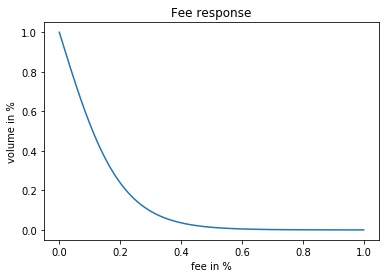

In [3]:
x_span = np.linspace(0,1, 200) 
y = fee_volume_response(x_span)
plt.xlabel('fee in %')
plt.ylabel('volume in %')
plt.title('Fee response')
plt.plot(x_span,y)

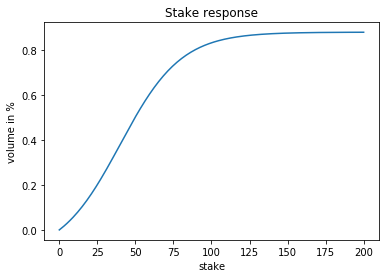

In [4]:
x_span = np.linspace(0,200, 200) 
y = stake_volume_response(x_span)
plt.xlabel('stake')
plt.ylabel('volume in %')
plt.title('Stake response')
plt.plot(x_span,y)

In [5]:
# Alternative initialization 

L_S = 120;
L_f = 1;

N_T = 250; delta_t = T / (N_T-1);
N_S = 30; 
N_f = 15; 

t_span = np.linspace(0,T, N_T)
f_span = np.linspace(0, L_f, N_f)
S_span = np.linspace(0, L_S, N_S)

In [6]:
def grid_idx_from(S,S_span):
    min_S = S_span[0]
    N_S = np.size(S_span)
    max_S = S_span[N_S-1]
    delta_S = (max_S-min_S)/(N_S-1)
    return max(min(int(round(S/delta_S)), N_S-1),0)


def update_value_at_time_idx(t_idx, a_vals, v_vals_old, v_vals_new):
    for f_idx in range(0,N_f):
        for S_idx in range(0,N_S):
            f_new = f_span[f_idx] - gamma * a_vals[t_idx, f_idx, S_idx] * delta_t 
            S_new = S_span[S_idx] + a_vals[t_idx, f_idx, S_idx] * delta_t 
            t_new = t_span[t_idx] 
            
            f_new_idx = grid_idx_from(f_new,f_span)
            S_new_idx = grid_idx_from(S_new,S_span)
            
            v_vals_new[t_idx,f_idx,S_idx] = running_gain(t_new, f_new, S_new)*delta_t + v_vals_old[t_idx+1, f_new_idx, S_new_idx]


def update_value(a_vals, v_vals_old, v_vals_new):
    for t_idx in reversed(range(0,N_T-1)):
        update_value_at_time_idx(t_idx, a_vals, v_vals_old, v_vals_new)

controls_lookup = np.matrix([
                     [0,-10], 
                     [1,0], 
                     [2,10],
])        



def calculate_one_step_gain(t_idx, f_idx, S_idx, v_vals):
    t_new = t_span[t_idx] 
    gains = np.zeros(np.size(controls_lookup[:,1]))
    for a in [-1,0,1]:
        f_new = f_span[f_idx] - gamma * a * delta_t 
        S_new = S_span[S_idx] + a * delta_t 
        f_new_idx = max(min(f_idx - a, N_f-1),0)
        S_new_idx = max(min(S_idx + a, N_S-1),0)
        gains[a+1] = running_gain(t_new, f_new, S_new)*delta_t + v_vals[t_idx+1, f_new_idx, S_new_idx]
    return gains

            
        
def update_policy_at_time_idx(t_idx, v_vals, a_vals):
    for f_idx in range(0,N_f):
        for S_idx in range(0,N_S):
            gains = calculate_one_step_gain(t_idx, f_idx, S_idx, v_vals)
            idx_maximizing = np.argmax(gains)
            a_vals[t_idx,f_idx, S_idx] = controls_lookup[idx_maximizing,1]
        
def update_policy(v_vals, a_vals):
    for t_idx in reversed(range(0,N_T-1)):
        update_policy_at_time_idx(t_idx, v_vals, a_vals)

In [7]:
max_iter = 100
max_err = 3/(N_f*N_S)

v_vals_new = np.zeros((np.size(t_span),np.size(f_span), np.size(S_span)))
v_vals_old = np.zeros((np.size(t_span),np.size(f_span), np.size(S_span)))
a_vals = np.zeros((np.size(t_span),np.size(f_span), np.size(S_span)))
a_vals_old = np.zeros((np.size(t_span),np.size(f_span), np.size(S_span)))
for iter_idx in range(0,max_iter):
    update_value(a_vals, v_vals_old, v_vals_new)
    a_vals_old = np.copy(a_vals)
    update_policy(v_vals_new, a_vals)
    diff_val = np.min(v_vals_new - v_vals_old)
    diff_pol = np.sum(np.abs(a_vals_old - a_vals))/(N_f*N_S)
    
    v_vals_old = np.copy(v_vals_new)
    
    if (diff_pol < 1e-8):
        print('Converged; change in policy fn. {0:1.5e}'.format(diff_pol))
        break
    else:
        print('Will run another iteration; change in policy fn. {0:1.5e}'.format(diff_pol))



Will run another iteration; change in policy fn. 2.34120e+03
Will run another iteration; change in policy fn. 1.10222e+01
Will run another iteration; change in policy fn. 5.48889e+00
Will run another iteration; change in policy fn. 5.51111e+00
Will run another iteration; change in policy fn. 5.48889e+00
Will run another iteration; change in policy fn. 5.51111e+00
Will run another iteration; change in policy fn. 1.62444e+01
Will run another iteration; change in policy fn. 5.42222e+00
Will run another iteration; change in policy fn. 1.07556e+01
Will run another iteration; change in policy fn. 5.37778e+00
Will run another iteration; change in policy fn. 5.35556e+00
Will run another iteration; change in policy fn. 5.33333e+00
Will run another iteration; change in policy fn. 1.58000e+01
Will run another iteration; change in policy fn. 5.24444e+00
Will run another iteration; change in policy fn. 5.22222e+00
Will run another iteration; change in policy fn. 5.20000e+00
Will run another iterati

Text(0.5, 0, 'value')

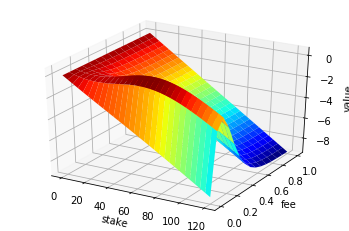

In [8]:
plotGridX, plotGridY = np.meshgrid(S_span, f_span)
fig = plt.figure()
ax1 = fig.gca(projection='3d')
surf = ax1.plot_surface(plotGridX, plotGridY, v_vals_new[0,:,:],linewidth=0, cmap=cm.jet, antialiased=True)
ax1.set_xlabel('stake')
ax1.set_ylabel('fee')
ax1.set_zlabel('value')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'linewidth'
  


Text(0.5, 0, 'a')

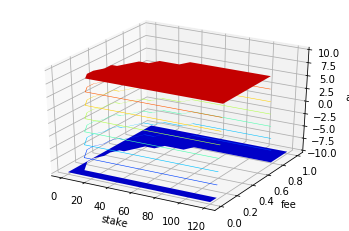

In [9]:
plotGridX, plotGridY =  np.meshgrid(S_span, f_span)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

surf = ax1.contourf(plotGridX, plotGridY, a_vals[N_T-2,:,:],linewidth=0, cmap=cm.jet, antialiased=True)
ax1.set_xlabel('stake')
ax1.set_ylabel('fee')
ax1.set_zlabel('a')

Text(0, 0.5, 'fees')

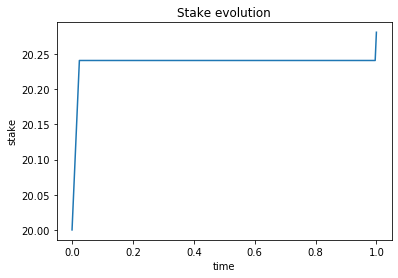

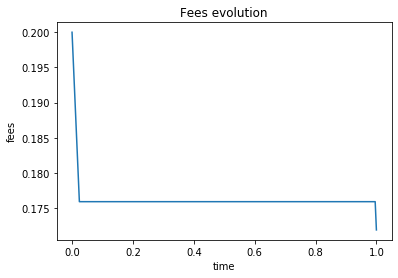

In [10]:
stakes = np.zeros(N_T+1)
stakes[0] = 20
fees = np.zeros(N_T+1)
fees[0] = 0.2

actions = np.zeros(N_T+1)
for i in range(0,N_T):
    f_idx = grid_idx_from(fees[i],f_span)
    S_idx = grid_idx_from(stakes[i],S_span)
    a = a_vals[i,f_idx,S_idx]
    fees[i+1] = fees[i] - gamma * a * delta_t
    stakes[i+1] = stakes[i] + a * delta_t

plt.plot(t_span, stakes[0:N_T])
plt.title('Stake evolution')
plt.xlabel('time')
plt.ylabel('stake')
fig = plt.figure()
plt.plot(t_span, fees[0:N_T])
plt.title('Fees evolution')
plt.xlabel('time')
plt.ylabel('fees')



In [11]:
np.shape(stakes[0:N_T])

(250,)

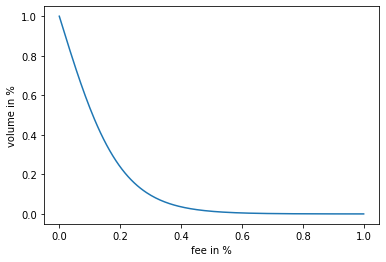

In [12]:
x_span = np.linspace(0,1, 200) 
y = fee_volume_response(x_span)
plt.xlabel('fee in %')
plt.ylabel('volume in %')
plt.plot(x_span,y)

In [13]:
y[100]

0.013055735821804554